# Introduction to Bootstrap with Polynomial Regression and KNN



## Introduction

Bootstrap is a powerful tool widely by statisticians and data scientists to quantify uncertainty associated with estimated parameters in the context of statistical learning methods. <br>

Bootstrap is the practice of estimating properties of an estimator, such as its standard-deviation and confidence interval, by measuring those properties when sampling from an approximating distribution. One standard choice for an approximating distribution is the empirical distribution function of the observed data.  <br>

In simple words, bootstrap is the practice of constantly repeating a modelling task, such as a linear regression, to estimate the variance of the parameters (betas) and consequently understand if they can be trusted or not. However, it would not make any sense to repeat such tasks with the same dataset, as the parameters would always return the equal, and the variance would be zero. Instead,  bootstrap consists of creating new fake/imaginary datasets, by sampling data with replacement from the dataset you are originally working with. <br>

Some machine learning methods have already incorporated bootstrap into its algorithm, more notably Random Forests that use bagging (bootstrap aggregating) to reduce the complexity of models that overfit the training data. <br>

#### Importing Libraries

In [13]:
# install.packages("reshape2")
# install.packages("ggplot2")
# install.packages("corrplot")
# install.packages("Cairo")
# install.packages("hrbrthemes")

# load libraries:
library(hrbrthemes)
library(reshape2)
library(ggplot2)
library(datasets)
library(corrplot)
library(dplyr)

## Regression Analysis
Does the richness of a country imply in a more lasting life expectancy? Easy question, the answer is Yes. At least in most cases. We will be working with a dataset from the website[ ] to try to model the relationship of these variables.  A first look in the data:

In [411]:
data <- read.csv('life-expectancy-vs-gdp-per-capita.csv') # import the data
colnames(data) <- c('Entity', 'code', 'Year', 'l_expect', 'GDP_per_capita', 'Pop') # improve names
data <- na.omit(data) # remove NA's

In [412]:
data <- data[data$GDP_per_capita > quantile(data$GDP_per_capita, .25) - 1.5*IQR(data$GDP_per_capita) & 
        data$GDP_per_capita < quantile(data$GDP_per_capita, .75) + 1.5*IQR(data$GDP_per_capita), ] # removing outliers

In [413]:
head(data)

,Entity,code,Year,l_expect,GDP_per_capita,Pop
,<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
1,Afghanistan,AFG,2015,63.377,1928,34414000
2,Africa,,2015,61.607,4684,1182439040
3,Albania,ALB,2015,78.025,10947,2891000
4,Algeria,DZA,2015,76.090,13024,39728000
8,Angola,AGO,2015,59.398,8631,27884000
11,Argentina,ARG,2015,76.068,19316,43075000


### Visualise the data

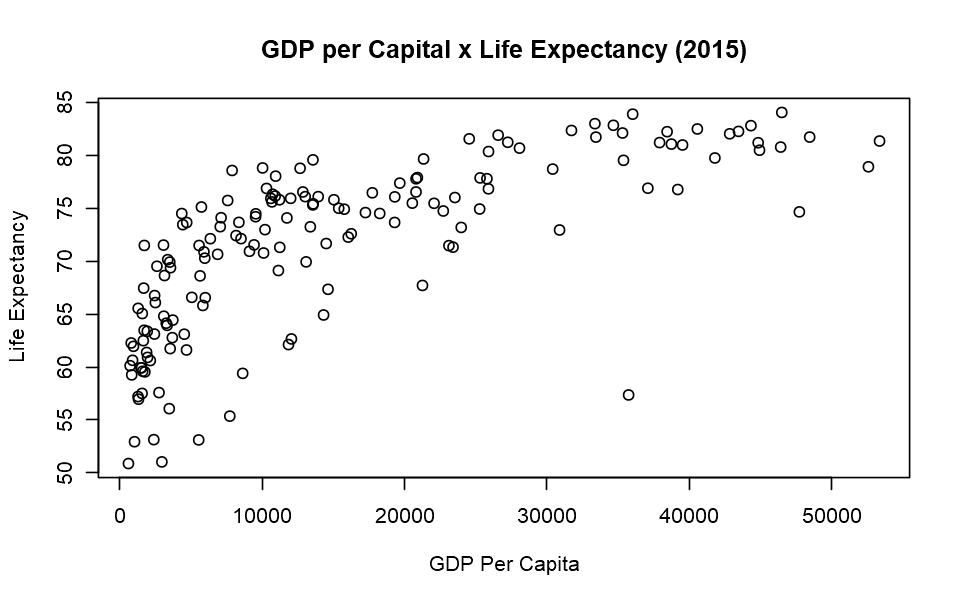

In [414]:
options(repr.plot.width=8, repr.plot.height=5) # area of display

plot(x=data$GDP_per_capita, y=data$l_expect, 
     xlab = "GDP Per Capita", 
     ylab = "Life Expectancy", 
     main = "GDP per Capital x Life Expectancy (2015)")

### Polynomial Regression
There is a clear relationship in the data. Countries with higher GDP-Per-Capita have an also higher life expectancy. The reason is not hard to guess. Better infrastructure, better health systems,  sanitation education and all that comes with economic development. It is worth noticing that we are working with GPD-per-Capita instead of GDP. The difference is that the number is divided by the number of citizens so that the number is not biased towards countries that have a vast population (such as China and India). <br>
However, it is also clear that the relationship between these variables is not linear, and therefore cannot be modelled by linear regression. Instead, we will use polynomial regression.


In [415]:
model <- lm(data$l_expect ~ data$GDP_per_capita + I(data$GDP_per_capita^2))
summary(model)


Call:
lm(formula = data$l_expect ~ data$GDP_per_capita + I(data$GDP_per_capita^2))

Residuals:
     Min       1Q   Median       3Q      Max 
-23.3124  -2.1618   0.6404   3.1210   9.8065 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               6.155e+01  8.096e-01   76.02  < 2e-16 ***
data$GDP_per_capita       1.021e-03  9.952e-05   10.26  < 2e-16 ***
I(data$GDP_per_capita^2) -1.359e-08  2.148e-09   -6.33 2.42e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.048 on 158 degrees of freedom
Multiple R-squared:  0.6137,	Adjusted R-squared:  0.6088 
F-statistic: 125.5 on 2 and 158 DF,  p-value: < 2.2e-16


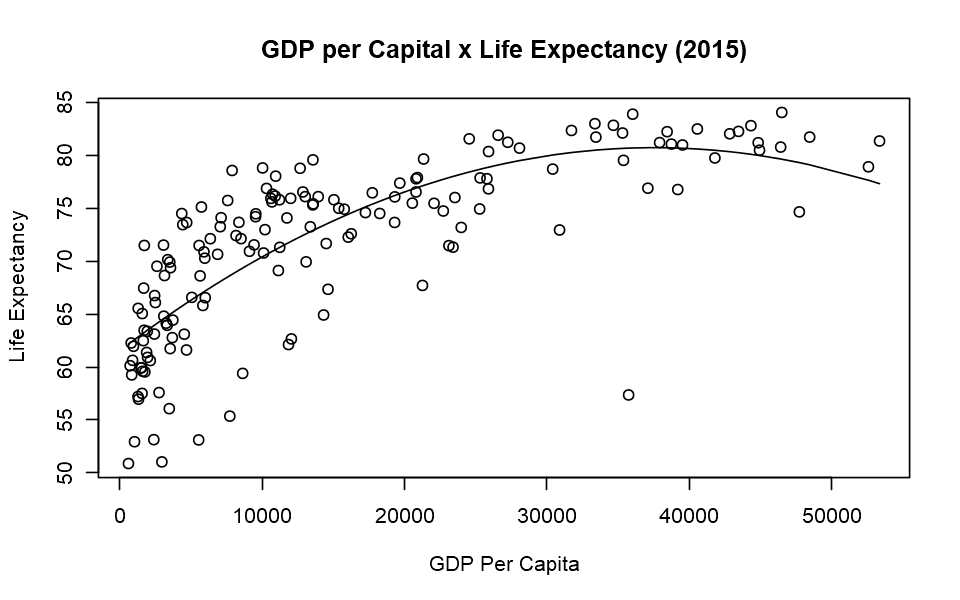

In [416]:
options(repr.plot.width=8, repr.plot.height=5) # area of display
plot(x=data$GDP_per_capita, y=data$l_expect, 
     xlab = "GDP Per Capita", 
     ylab = "Life Expectancy", 
     main = "GDP per Capital x Life Expectancy (2015)")


myPredict <- predict(model)
ix <- sort(data$GDP_per_capita, index.return=T)$ix
lines(data$GDP_per_capita[ix], myPredict[ix]) 

### Bootstrap

In [417]:
# define a function that generates sample indixes based on bootstrap technique
set.seed(1234)
boot <- function (original.size, sample.size = original.size, times){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

In [418]:
# just to see if it works!
boot.indx <- boot(nrow(data), 161, 100)

In [419]:
K = 100
miss <- data.frame('K'=1:K, 'beta0'= 0, 'beta1' = 0, 'beta2' = 0)

for (k in 1:K){
    
    #### save sample indices that were selected by bootstrap
    indx <- boot.indx[k,]
                
    #### calculate and record the train and test missclassification rates
    miss[k,2:4] <- lm(l_expect ~ GDP_per_capita + I(GDP_per_capita^2), data = data[indx , ])$coefficients
    
    } 

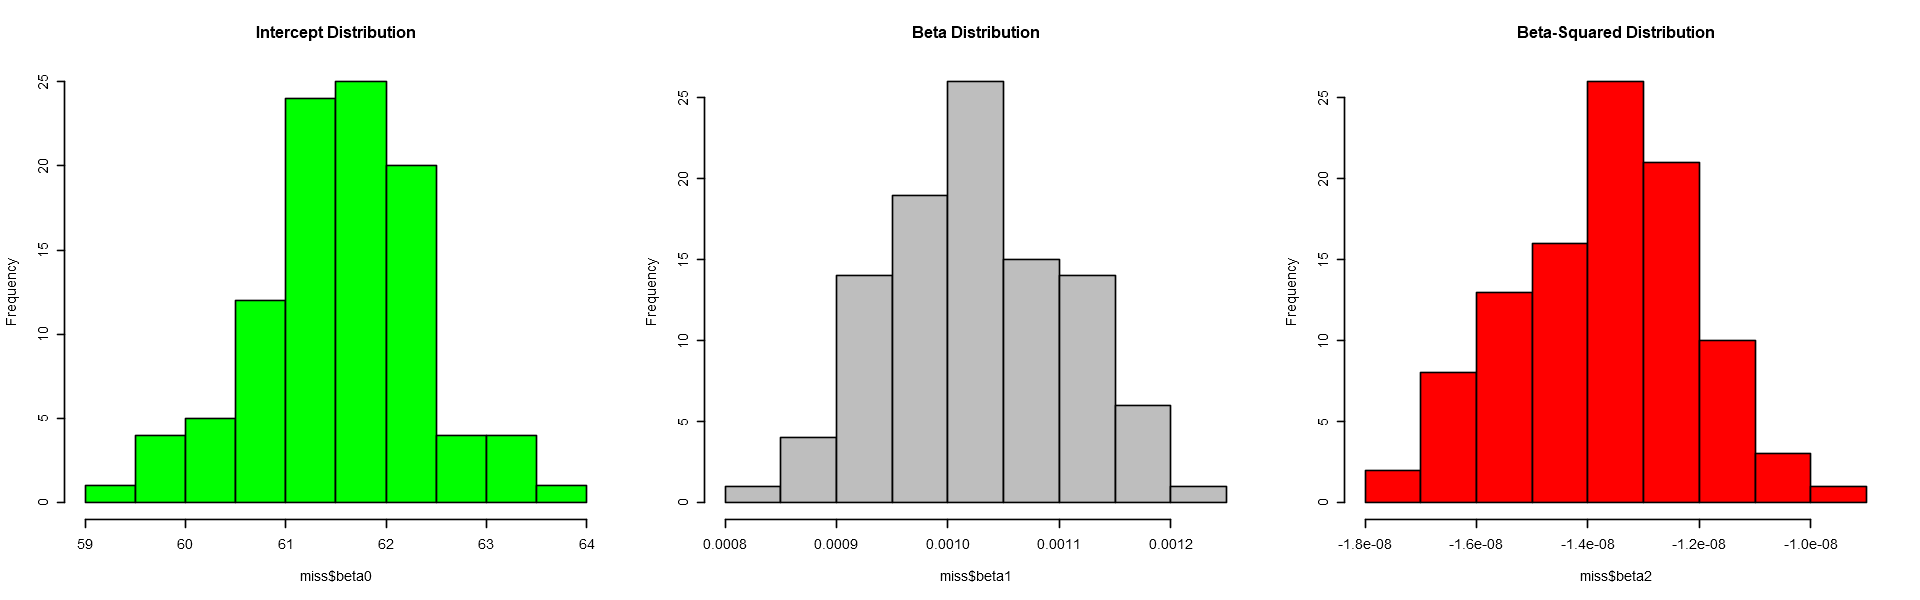

In [420]:
options(repr.plot.width=16, repr.plot.height=5) # area of display
par(mfrow=c(1,3))

hist(miss$beta0, main = "Intercept Distribution", col = 'green')
hist(miss$beta1, main = "Beta Distribution", col = 'grey')
hist(miss$beta2, main = "Beta-Squared Distribution", col = 'red')

### Plot Multiple Lines

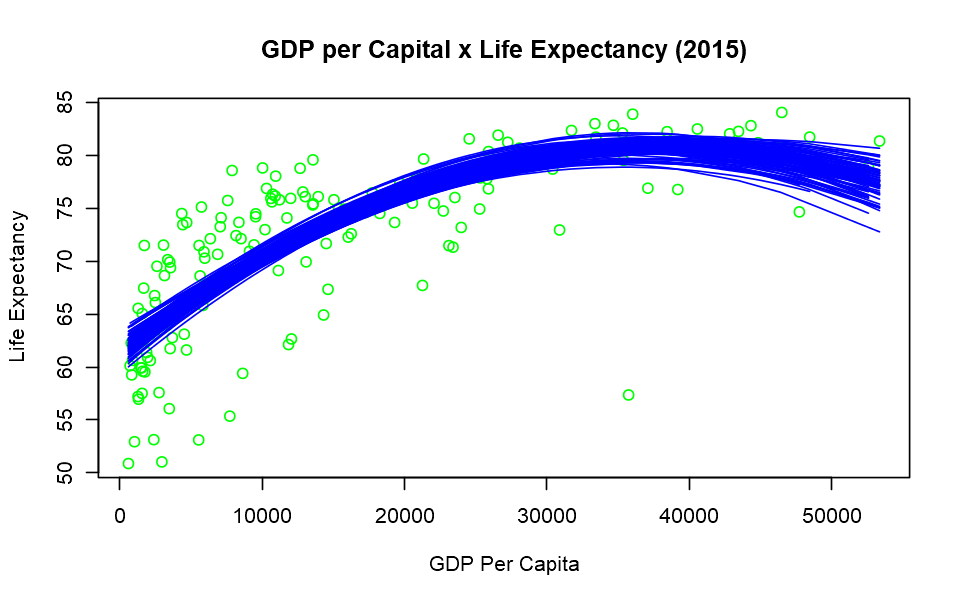

In [421]:
options(repr.plot.width=8, repr.plot.height=5) # area of display

plot(x=data$GDP_per_capita, y=data$l_expect, 
     xlab = "GDP Per Capita", 
     ylab = "Life Expectancy", 
     col = "green",
     main = "GDP per Capital x Life Expectancy (2015)")

for (k in 1:nrow(boot.indx)){
    
    data_indx = data[indx , ]
    indx <- boot.indx[k,]
    model <- lm(l_expect ~ GDP_per_capita + I(GDP_per_capita^2), data = data_indx)
    myPredict <- predict(model)
    ix <- sort(data_indx$GDP_per_capita, index.return=T)$ix
    lines(data_indx$GDP_per_capita[ix], myPredict[ix], col = 'blue') 
}

#### Find Value of Parameters

In [471]:
beta0_mean <- mean(miss[,2])
beta1_mean <- mean(miss[,3])
beta2_mean <- mean(miss[,4])
beta0_sd <- sd(miss[,2])
beta1_sd <- sd(miss[,3])
beta2_sd <- sd(miss[,4])
beta0_sup <- beta0_mean + qnorm(.95)*beta0_sd/sqrt(nrow(miss)) 
beta1_sup <- beta1_mean + qnorm(.95)*beta1_sd/sqrt(nrow(miss))
beta2_sup <- beta2_mean + qnorm(.95)*beta2_sd/sqrt(nrow(miss))
beta0_inf <- beta0_mean - qnorm(.95)*beta0_sd/sqrt(nrow(miss))
beta1_inf <- beta1_mean - qnorm(.95)*beta1_sd/sqrt(nrow(miss))
beta2_inf <- beta2_mean - qnorm(.95)*beta2_sd/sqrt(nrow(miss))

#### Plot with the confidence interval

In [472]:
data$predict_mean <- beta0_mean + beta1_mean*data$GDP_per_capita + beta2_mean*data$GDP_per_capita^2
data$predict_sup <- beta0_sup + beta1_sup*data$GDP_per_capita + beta2_sup*data$GDP_per_capita^2
data$predict_inf <- beta0_inf + beta1_inf*data$GDP_per_capita + beta2_inf* data$GDP_per_capita^2

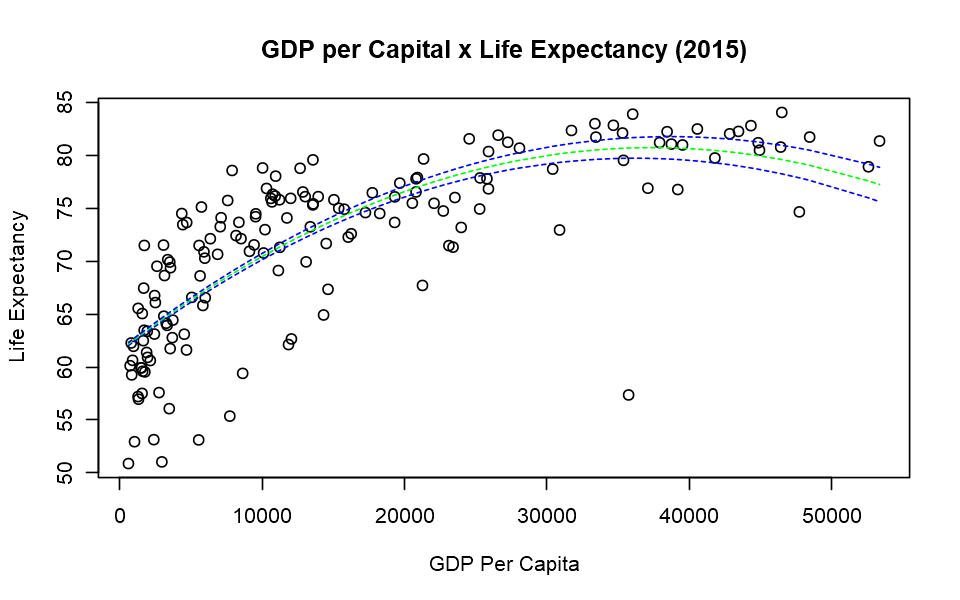

In [473]:
options(repr.plot.width=8, repr.plot.height=5) # area of display
plot(x=data$GDP_per_capita, y=data$l_expect, 
     xlab = "GDP Per Capita", 
     ylab = "Life Expectancy", 
     main = "GDP per Capital x Life Expectancy (2015)")


ix <- sort(data$GDP_per_capita, index.return=T)$ix
lines(data$GDP_per_capita[ix], data$predict_inf[ix],  col="blue", lty=2, type = "l") 
lines(data$GDP_per_capita[ix], data$predict_mean[ix],  col="green", lty=2, type = "l") 
lines(data$GDP_per_capita[ix], data$predict_sup[ix],  col="blue", lty=2, type = "l") 


##  K-Nearest Neighbour Classifier

KNN is a simple non-parametric model supervised learning. KNN is a lazy learner that stores all training data points and their labels in memory, and predict the class label for a new data point based on its similarity to the training data (in fact the stored training data points can be considered as parameters).

Consider a training dataset containing (x,t) pairs where $x$ is the input and $t$ is the target class label. Suppose we are given a similarity measure $sim(x_1,x_2)$ which gives the similarity score when fed with two data points. Given a test data point x, the K-nearest neighbour classifier works as follows:
<ul>
	<li>Select the top K most similar data points to x from the training set</li>
	<li>Look at the label of the K-nearest neighbours and select the label which has the majority vote.</li>
</ul>
If the classes are equally common among the neighbours (e.g., two positive and two negative neighbours in binary classification when K=4), the test datapoint is randomly assigned to one of the classes. For example, Figure <strong>A.1</strong> (below) illustrates such situation where the test datapoint (shown by <span style="color: #00ff00;">green</span>) has exactly two neighbours from each class (marked by <span style="color: #ff0000;">red</span> and <span style="color: #3366ff;">blue</span>).

<a href="http://www.saedsayad.com/k_nearest_neighbors.htm" rel="attachment wp-att-92100"><img class="wp-image-92100 size-full" src="https://www.alexandriarepository.org/wp-content/uploads/20160413152921/A.1.png" alt="Figure A.1: KNN for Classification. The green dot indicates a sample with an unknown class label, while red and blue samples are training observation from default and non-default classes, respectively. Source: http://www.saedsayad.com/k_nearest_neighbors.htm" width="497" height="274" /></a> 

> Figure A.1: KNN for Classification. The green dot indicates a sample with an unknown class label, while red and blue samples are training observation from default and non-default classes, respectively. Source: http://www.saedsayad.com/k_nearest_neighbors.htm

### Steps
<ol>
	<li>Load the iris dataset and divide it to separate training and testing sets,</li>
    <li>Define a function that calculates the majority vote,</li>
    <li>Define KNN function that takes training labeled samples, testing samples, $K$ and a distance metric and predicts the class labels for the testing samples,</li>
	<li>Apply KNN where for some values of $K$ and report training and testing error</li>
	<li>Plot training and testing error versus $1/K$ where $K \in \{1,\cdots,100\}$</li>
</ol>

In [41]:
data(iris)
# take a look at the data
head(iris)
# Shown are 4 measurements (petal & sepal width & length) for 3 species of iris flowers, where sepal is: 
# "One of the usually separate, green parts that surround and protect the flower bud" (or petals)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [42]:
dim(iris) # 150 x 5 records

[1] 150   5

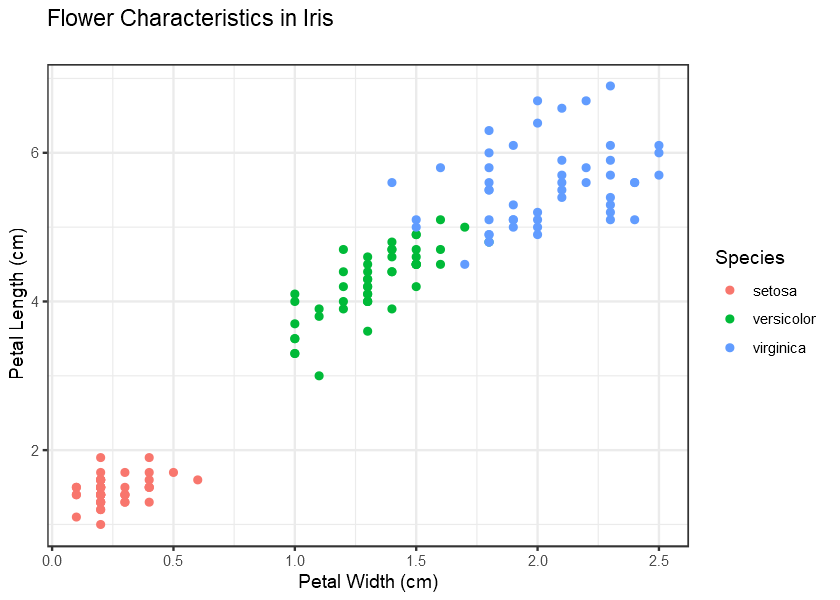

In [43]:
options(repr.plot.width=7, repr.plot.height=5) # area of display

# Plotting the data
ggplot(iris,aes(x=Petal.Width,y=Petal.Length,colour=Species)) +
  geom_point() +
  xlab("Petal Width (cm)") +
  ylab("Petal Length (cm)") +
  theme_bw() +
  ggtitle("Flower Characteristics in Iris\n")

### Training and Testing Sets

In [44]:
# set random seed
set.seed(1234)
# permute iris, shuffle or mix them up
iris <- iris[sample(1:nrow(iris),nrow(iris)),]
# create  training and testing subsets:
train.index = 1:100
train.data <- iris[train.index, -5] # grab the first 100 records, leave out the species (last column)
train.label <- iris[train.index, 5]
test.data <- iris[-train.index, -5] # grab the last 50 records, leave out the species (last column)
test.label <- iris[-train.index, 5]

dim(train.data) # 100 records
dim(test.data) # 50 records

[1] 100   4

[1] 50  4

### Majority Vote

In [45]:
# define an auxiliary function that calculates the majority votes (or mode!)
majority <- function(x) {
   uniqx <- unique(x)
   uniqx[which.max(tabulate(match(x, uniqx)))]
}

### KNN Classifier

In [46]:
# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        
        ###... and calculate the predicted labels according to the majority vote
        test.label[i]<- (majority(train.label[nn]))
    }
    
    ## return the class labels as output
    return (test.label)
}

In [47]:
# let see what is the prediciton of our knn for test samples when K=4
knn(train.data, train.label, test.data, K=4)

[1] virginica  versicolor setosa     setosa     versicolor versicolor
 [7] virginica  setosa     virginica  versicolor versicolor versicolor
[13] versicolor versicolor setosa     virginica  versicolor setosa    
[19] versicolor virginica  virginica  versicolor setosa     setosa    
[25] virginica  setosa     virginica  virginica  virginica  versicolor
[31] setosa     setosa     setosa     virginica  versicolor versicolor
[37] versicolor versicolor setosa     setosa     virginica  versicolor
[43] setosa     setosa     versicolor setosa     versicolor virginica 
[49] setosa     setosa    
Levels: setosa versicolor virginica

In [48]:
# and a confusion matrix for K = 5
prop.table(table(knn(train.data, train.label, test.data, K=5), test.label))*100

            test.label
             setosa versicolor virginica
  setosa         36          0         0
  versicolor      0         34         0
  virginica       0          2        28

In [49]:
# calculate the train and test missclassification rates for K in 1:100 
# THIS MAY TAKE A FEW MINUTES TO COMPLETE!
miss <- data.frame('K'=1:100, 'train'=rep(0,100), 'test'=rep(0,100))
for (k in 1:100){
    miss[k,'train'] <- sum(knn(train.data, train.label, train.data, K=k) != train.label)/nrow(train.data)*100
    miss[k,'test'] <-  sum(knn(train.data, train.label, test.data, K=k)  != test.label)/nrow(test.data)*100
}

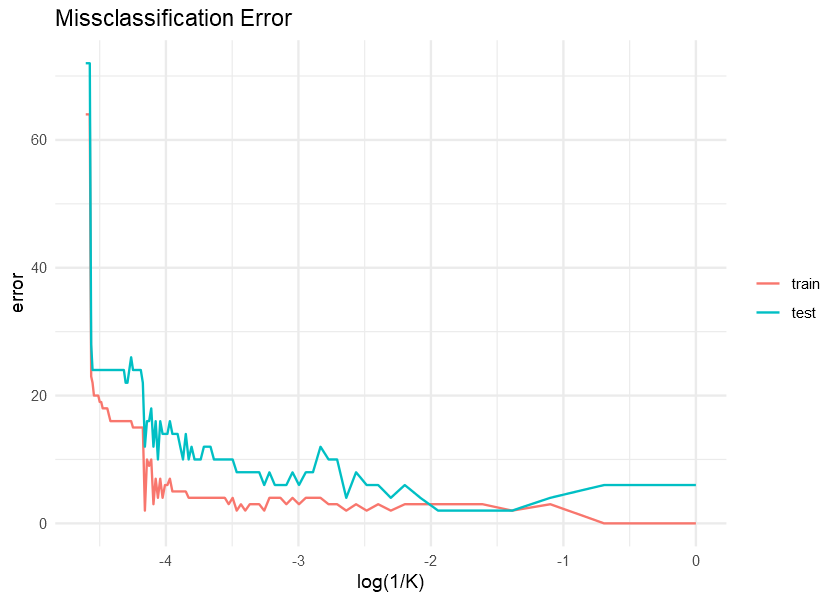

In [50]:
# plot misclassification percentage for train and test data sets
miss.m <- melt(miss, id='K') # reshape for visualization
names(miss.m) <- c('K', 'type', 'error')
ggplot(data=miss.m, aes(x=log(1/K), y=error, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Missclassification Error")

Observations:

- As $K$ increases, the complexity of the KNN classifier decreases
- There is a positive relationship between $K$ and the training and testing error
- As the complexity of the classifier increases the training and testing error differ. This is because the model overfits.
- The model underfits when $log(1/k) < -4$ and overfits when $log(1/k) > -1$

### Bootstrapping - Application in KNN Classifer 
We implement this technique to assess variations in the prediction of KNN classifier.  


In [53]:
# fix the parameters
K <- 30           # Maximum K for KNN 
L <- 40           # number of datasets
N <- 50           # size of datasets

# generate bootstrap indices:
boot.indx <- boot(nrow(train.data), N, L)

# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

# THIS MAY TAKE A FEW MINUTES TO COMPLETE
## for every k values:
for (k in 1: K){
    
    ### for every dataset sizes:
    for (l in 1:L){
        
        #### calculate iteration index i
        i <- (k-1)*L+l
        
        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        #### save the value of k and l
        miss[i,'K'] <- k
        miss[i,'L'] <- l
        
        #### calculate and record the train and test missclassification rates
        miss[i,'test'] <-  sum(knn(train.data[indx, ], train.label[indx], test.data, K=k)  != test.label)/nrow(test.data)*100
    } 
}

### Visalization
Let see the output. In the following Jitter Plot, each point corrspends to the error (measured on the fixed test set) of the KNN classifier trained by a random training sample generated during our bootstrap sampling. 

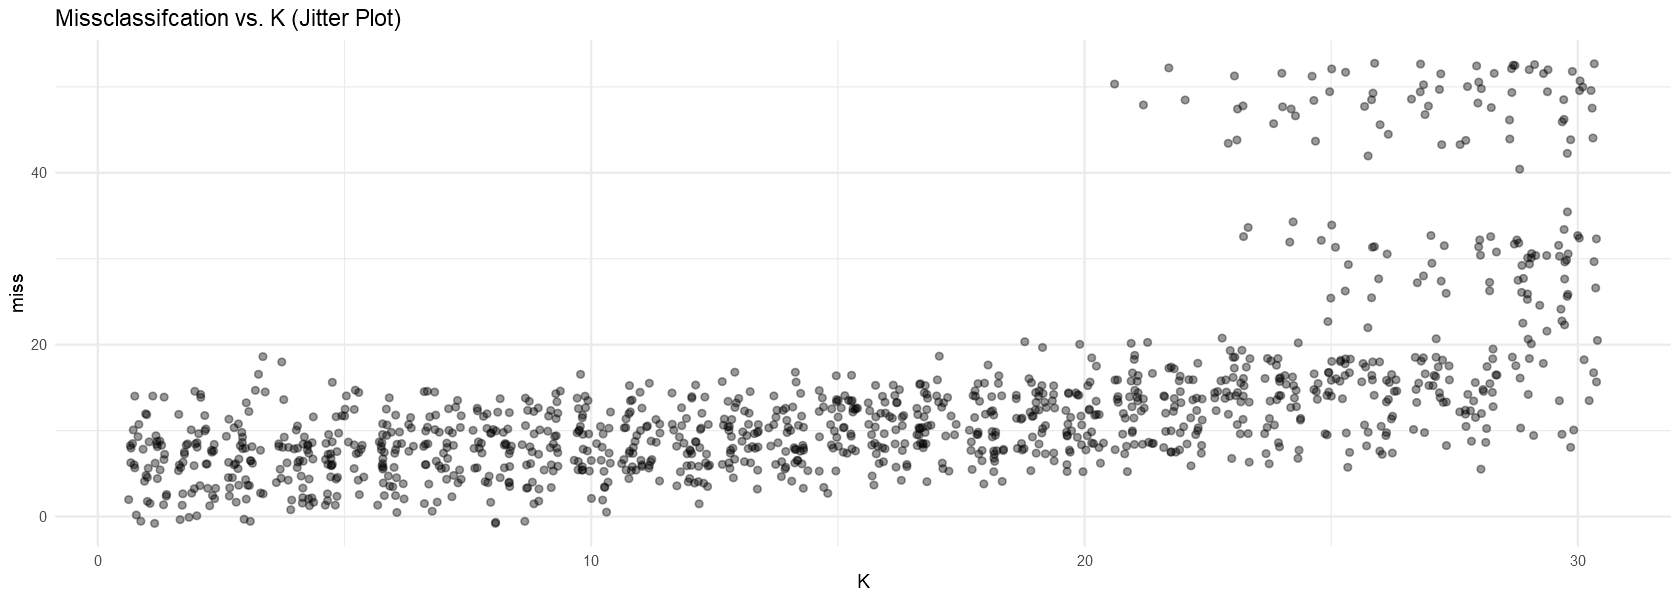

In [75]:
# plot misclassification percentage for train and test data sets
miss.m <- melt(miss, id=c('K', 'L')) # reshape for visualization
names(miss.m) <- c('K', 'L', 'type', 'miss')

ggplot(data=miss.m, aes(x=K, miss)) + geom_jitter(alpha=0.4)  + 
    scale_fill_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Jitter Plot)') + theme_minimal() 

Now we produce the box plot of the error numbers (each of which corresponding to a sample in our bootstrap sampling) we have obtained for our test set for each value of K. 

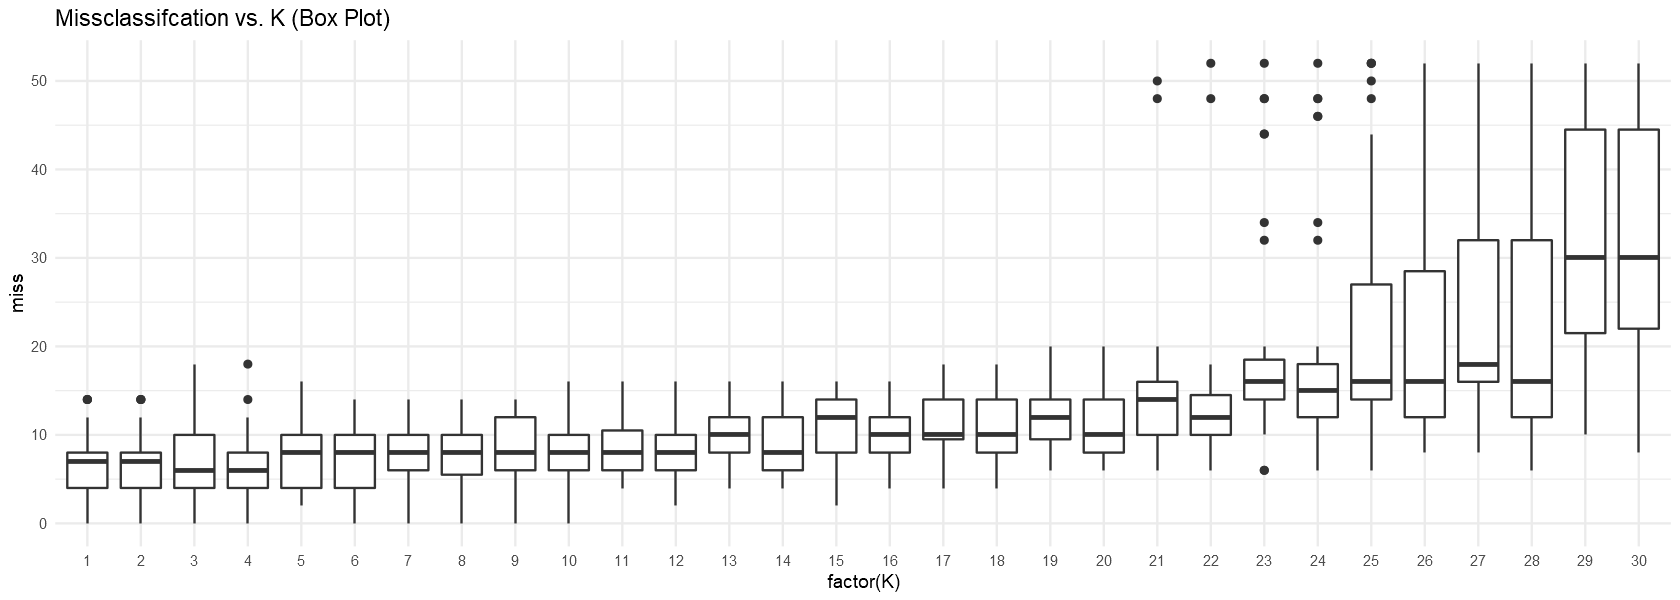

In [79]:
options(repr.plot.width=14, repr.plot.height=5) # area of display

ggplot(data=miss.m[miss.m$type=='test',], aes(factor(K), miss)) + geom_boxplot()  + 
    scale_color_discrete() + ggtitle('Missclassifcation vs. K (Box Plot)') + theme_minimal() 

# ignore the warnings (because of ignoring outliers)
options(warn=-1)

Observations:

As $K$ increases, the test error and its uncertainty increase significantly.